Libraries

In [156]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [157]:
os.chdir('/Users/arifakkan/Downloads/Project/Data')

In [158]:
product='tomato'
#product='cucumber'
#product='eggplant'

Functions

In [159]:
def graphweather(df, x, y, y_label,graph_title, column_name=None):
    """
    df: name of dataframe
    x_value = x axis 
    y-value = y axis
    column_name = set hue
    legend_title = title of legend
    y_label = y axis label 
    graph_title = title for graph 
    """
    plt.figure(figsize=(10,6))
    graph_name = sns.lineplot(data=df, x=x, y=y, hue=column_name)
    plt.xlabel('Time')
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show(graph_name)
    return graph_name


def stationary_test(dataset, variable):
    # Apply Augmented Dickey-Fuller test on the residual
    adf_test = adfuller(dataset[variable].dropna())

    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])

    # Interpret the results based on the p-value
    if adf_test[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary and may need further differencing or transformation.")
def import_weather(file):
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['dt'], unit='s')
    # Set the date column to just the date part (removing the time)
    df['day'] = df['date'].dt.date

    df=df[df.date>=pd.to_datetime('2005.1.1')]
    df=df[df.date<pd.to_datetime('2020.1.1')]
    return df



Weather Data

In [160]:
# df = pd.read_csv('weather.csv')
# df['date'] = pd.to_datetime(df['dt'], unit='s')
# # Set the date column to just the date part (removing the time)
# df['day'] = df['date'].dt.date

# df=df[df.date>=pd.to_datetime('2005.1.1')]
# df=df[df.date<pd.to_datetime('2020.1.1')]

df=import_weather('weather.csv')
df.set_index('date', inplace=True)
# dforg = pd.read_csv('weather.csv')
# dforg['date'] = pd.to_datetime(dforg['dt'], unit='s')
# # Set the date column to just the date part (removing the time)
# dforg['day'] = dforg['date'].dt.date

dforg=import_weather('weather.csv')
dforg.set_index('date', inplace=True)

Weather Expectations from Official Sources

In [161]:
ant_avg= pd.read_excel('antalyaavg.xlsx', header=0, index_col=0).T
ant_avg = ant_avg.astype(float)
ant_avg

,AverageTemp,AverageMax,AverageMin,AverageSunnyLength,AverageRainyDays,AverageMonthlyPrec
1,9.8,15.0,5.9,4.9,11.50,210.6
2,10.8,15.9,6.5,5.7,9.60,112.7
3,13.1,18.4,8.3,6.5,7.60,94.5
4,16.4,21.8,11.3,7.7,6.43,63.1
5,20.9,26.4,15.7,9.4,4.97,37.0
6,25.7,31.6,20.1,11.0,2.13,10.1
7,28.9,34.9,23.4,11.1,0.67,4.0
8,29.0,34.9,23.7,10.5,0.60,5.0
9,25.6,31.7,20.1,9.1,1.93,22.0
10,20.9,27.3,15.9,7.5,4.87,76.6


In [162]:
dfdesc=df[['temp', 'rain_1h', 'snow_1h','weather_main']]
summary_stats = dfdesc.describe()

# If you want to include categorical variables, you can do:
summary_stats_all = dfdesc.describe(include='all')

print(summary_stats_all)

                 temp       rain_1h  snow_1h weather_main
count   133512.000000  19596.000000      0.0       133512
unique            NaN           NaN      NaN           11
top               NaN           NaN      NaN        Clear
freq              NaN           NaN      NaN        56393
mean        19.701939      1.006815      NaN          NaN
std          7.897508      1.187170      NaN          NaN
min         -1.000000      0.100000      NaN          NaN
25%         13.410000      0.260000      NaN          NaN
50%         19.120000      0.580000      NaN          NaN
75%         25.950000      1.300000      NaN          NaN
max         44.950000     16.760000      NaN          NaN


Temperatures

In [163]:
monthly_temp = pd.DataFrame(df['temp'].resample('M').mean())
monthly_temp['month'] = monthly_temp.index.month
monthly_temp['expected'] = monthly_temp['month'].map(ant_avg['AverageTemp'])

# Create final dataframe
final=pd.DataFrame(monthly_temp.index)
final['extreme']=0


# Calculate the difference
monthly_temp['tempdiff'] = (monthly_temp['temp'] - monthly_temp['expected'])/monthly_temp['expected']
stationary_test(monthly_temp,'tempdiff')
stationary_test(monthly_temp,'temp')

monthly_temp['month'] = monthly_temp.index.month
monthly_temp_avg_org = dforg['temp'].resample('M').mean()

# Calculate the long-term monthly average and standard deviation for rainfall
long_term_monthly_temp_avg = monthly_temp_avg_org.groupby(monthly_temp_avg_org.index.month).mean()
long_term_monthly_temp_std = monthly_temp_avg_org.groupby(monthly_temp_avg_org.index.month).std()

hot_months=pd.DataFrame()
cold_months=pd.DataFrame()

# Loop through each month in the monthly average data
for month in monthly_temp.index.month.unique():
    # # Get the threshold for this month
    threshold_hot = long_term_monthly_temp_avg[month]+ 2 * long_term_monthly_temp_std[month]
    threshold_cold = long_term_monthly_temp_avg[month] - 2 * long_term_monthly_temp_std[month]
    # Find entries in this month that are below the threshold
    hot = monthly_temp[(monthly_temp.index.month == month) & (monthly_temp['temp'] > threshold_hot)]
    cold = monthly_temp[(monthly_temp.index.month == month) & (monthly_temp['temp'] < threshold_cold)]
    hot_months = pd.concat([hot_months,hot])
    cold_months = pd.concat([cold_months,cold])

final.loc[final['date'].isin(hot_months.index), 'extreme'] = 1
final.loc[final['date'].isin(cold_months.index), 'extreme'] = 1



ADF Statistic: -8.031342
p-value: 0.000000
The series is stationary.
ADF Statistic: -3.440557
p-value: 0.009652
The series is stationary.


## Min  Max Temps

In [164]:
daily_min = df['temp'].resample('D').min()
daily_max = df['temp'].resample('D').max()

# Combine min and max into a single DataFrame
daily_extremes = pd.DataFrame({'min_temp': daily_min, 'max_temp': daily_max})

# Resample to get monthly averages of daily minimum and maximum temperatures
monthly_temp['temp_min'] = daily_extremes['min_temp'].resample('M').mean()
monthly_temp['temp_max']= daily_extremes['max_temp'].resample('M').mean()

monthly_temp['expected_min'] = monthly_temp['month'].map(ant_avg['AverageMin'])
monthly_temp['mindiff'] = (monthly_temp['temp_min'] - monthly_temp['expected_min'])/monthly_temp['expected_min']

monthly_temp['expected_max'] = monthly_temp['month'].map(ant_avg['AverageMax'])
monthly_temp['maxdiff'] = (monthly_temp['temp_max'] - monthly_temp['expected_max'])/monthly_temp['expected_max']
stationary_test(monthly_temp,'tempdiff')
stationary_test(monthly_temp,'temp')

stationary_test(monthly_temp,'temp_min')
stationary_test(monthly_temp,'temp_max')
stationary_test(monthly_temp,'maxdiff')
stationary_test(monthly_temp,'mindiff')

monthly_temp.reset_index(inplace=True)
monthly_temp.drop(['expected', 'month', 'expected_min','temp_min', 'temp_max', 'expected_max', 'temp'], axis=1 ,inplace=True)

final= final.merge(monthly_temp, on='date')

ADF Statistic: -8.031342
p-value: 0.000000
The series is stationary.
ADF Statistic: -3.440557
p-value: 0.009652
The series is stationary.
ADF Statistic: -3.772108
p-value: 0.003206
The series is stationary.
ADF Statistic: -3.177689
p-value: 0.021313
The series is stationary.
ADF Statistic: -9.011529
p-value: 0.000000
The series is stationary.
ADF Statistic: -7.552899
p-value: 0.000000
The series is stationary.


## Precipitation

In [165]:
df['rain'] = df['rain_1h'].fillna(0)
monthly_rain = pd.DataFrame(df['rain'].resample('M').sum())
monthly_rain['month'] = monthly_rain.index.month
stationary_test(monthly_rain,'rain')

monthly_rain['expected_prec'] = monthly_rain['month'].map(ant_avg['AverageMonthlyPrec'])
monthly_rain['raindiff'] = (monthly_rain['rain'] - monthly_rain['expected_prec'])/ monthly_rain['expected_prec']
stationary_test(monthly_rain,'raindiff')


# Apply logarithmic transformation
monthly_rain['rainlogs'] = np.log(monthly_rain['rain'])
monthly_rain['raind'] = monthly_rain['rainlogs'].diff()
monthly_rain['raind'] = monthly_rain['rain'].diff(12)

stationary_test(monthly_rain,'raind')

dforg['rain'] = dforg['rain_1h'].fillna(0)
monthly_rain_avg_org = dforg['rain'].resample('M').sum()

# Calculate the long-term monthly average and standard deviation for rainfall
long_term_monthly_rain_avg = monthly_rain_avg_org.groupby(monthly_rain_avg_org.index.month).mean()
long_term_monthly_rain_std = monthly_rain_avg_org.groupby(monthly_rain_avg_org.index.month).std()

# Initialize an empty DataFrame to store cold months data
rainy_months = pd.DataFrame()
dry_months=pd.DataFrame()

# Loop through each month in the monthly average data
for month in monthly_rain.index.month.unique():
    # # Get the threshold for this month
    threshold_rainy = long_term_monthly_rain_avg[month]+ 2 * long_term_monthly_rain_std[month]
    threshold_dry = long_term_monthly_rain_avg[month] - 2 * long_term_monthly_rain_std[month]
    # Find entries in this month that are below the threshold
    rainy = monthly_rain[(monthly_rain.index.month == month) & (monthly_rain['rain']> threshold_rainy)]
    dry = monthly_rain[(monthly_rain.index.month == month) & (monthly_rain['rain'] < threshold_dry)]
    
    # Append the results to the cold_months DataFrame
    rainy_months = pd.concat([rainy_months,rainy])
    dry_months = pd.concat([dry_months,dry])

final.loc[final['date'].isin(rainy_months.index), 'extreme'] = 1
final.loc[final['date'].isin(dry_months.index), 'extreme'] = 1


monthly_rain.reset_index(inplace=True)
monthly_rain.drop(['expected_prec', 'month','rain','raindiff','rainlogs'], axis=1,inplace=True)
final= final.merge(monthly_rain, on='date')

ADF Statistic: -3.214785
p-value: 0.019145
The series is stationary.
ADF Statistic: -11.058797
p-value: 0.000000
The series is stationary.
ADF Statistic: -5.449339
p-value: 0.000003
The series is stationary.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Humidity

In [166]:
monthly_hum = pd.DataFrame(df['humidity'].resample('M').mean())
stationary_test(monthly_hum, 'humidity')

monthly_hum.reset_index(inplace=True)
monthly_hum = monthly_hum.rename(columns={'humidity': 'hum'})
final= final.merge(monthly_hum, on='date')

ADF Statistic: -8.324971
p-value: 0.000000
The series is stationary.


## Extremes

In [167]:
extreme_conditions = [
    'heavy intensity rain', 'thunderstorm with heavy rain', 'heavy intensity shower rain',
    'proximity tornado', 'very heavy rain', 'thunderstorm', 'proximity thunderstorm',
    'snow', 'heavy intensity drizzle', 'sleet']

monthly_extremes = df.resample('M').apply(lambda x: (x['weather_description'].isin(extreme_conditions)).sum())

monthly_extremes_avg_org = dforg.resample('M').apply(lambda x: (x['weather_description'].isin(extreme_conditions)).sum())

# Calculate the long-term monthly average and standard deviation for rainfall
long_term_extremes_avg = monthly_extremes_avg_org.groupby(monthly_extremes_avg_org.index.month).mean()
long_term_extremes_std = monthly_extremes_avg_org.groupby(monthly_extremes_avg_org.index.month).std()

# Initialize an empty DataFrame to store cold months data
ext_months = pd.DataFrame()


# Loop through each month in the monthly average data
for month in monthly_extremes.index.month.unique():
    # # Get the threshold for this month
    threshold_ext = long_term_extremes_avg[month]+ 2 * long_term_extremes_std[month]
    # Find entries in this month that are below the threshold
    ext = monthly_extremes[(monthly_extremes.index.month == month) & (monthly_extremes> threshold_ext)]
    
    # Append the results to the cold_months DataFrame
    ext_months = pd.concat([ext_months,ext])
final.loc[final['date'].isin(ext_months.index), 'extreme'] = 1


In [168]:
count_of_ones = final['extreme'].value_counts().get(1, 0)

print(count_of_ones)

15


In [169]:
print(final)

          date  extreme  tempdiff   mindiff   maxdiff   raind        hum
0   2005-01-31        0  0.117070  0.343576 -0.009161     NaN  66.951507
1   2005-02-28        0 -0.062799  0.074835 -0.136523     NaN  62.997093
2   2005-03-31        0  0.050234  0.138904  0.005137     NaN  62.967785
3   2005-04-30        0  0.054499  0.098555  0.026330     NaN  57.464730
4   2005-05-31        0  0.027993  0.020156  0.010887     NaN  58.923077
..         ...      ...       ...       ...       ...     ...        ...
175 2019-08-31        0  0.040442  0.087696  0.028515   -0.39  49.615591
176 2019-09-30        0  0.036796  0.100514 -0.016393   53.09  55.048276
177 2019-10-31        1  0.137358  0.197748  0.044334  -27.74  52.752000
178 2019-11-30        0  0.169613  0.255483  0.055093   33.59  62.453457
179 2019-12-31        1  0.113165  0.170925  0.056114  248.49  67.600246

[180 rows x 7 columns]


## WEATHER FROM OTHER CITIES

In [170]:
df_izm= import_weather('izmir.csv')
df_izm.set_index('date', inplace=True)
df_bur= import_weather('bursa.csv')
df_bur.set_index('date', inplace=True)
df_man= import_weather('manisa.csv')
df_man.set_index('date', inplace=True)

### Manisa

In [171]:
man_avg= pd.read_excel('manavg.xlsx', header=0, index_col=0).T
man_avg = man_avg.astype(float)

In [172]:
monthly_temp = pd.DataFrame(df_man['temp'].resample('M').mean())
monthly_temp['month'] = monthly_temp.index.month
monthly_temp['expected'] = monthly_temp['month'].map(man_avg['AverageTemp'])
# Calculate the difference
monthly_temp['tempdiff'] = (monthly_temp['temp'] - monthly_temp['expected'])/monthly_temp['expected']
daily_min = df_man['temp'].resample('D').min()
daily_max = df_man['temp'].resample('D').max()

# Combine min and max into a single DataFrame
daily_extremes = pd.DataFrame({'min_temp': daily_min, 'max_temp': daily_max})

# Resample to get monthly averages of daily minimum and maximum temperatures
monthly_temp['temp_min'] = daily_extremes['min_temp'].resample('M').mean()
monthly_temp['temp_max']= daily_extremes['max_temp'].resample('M').mean()

monthly_temp['expected_min'] = monthly_temp['month'].map(man_avg['AverageMin'])
monthly_temp['mindiff'] = (monthly_temp['temp_min'] - monthly_temp['expected_min'])/monthly_temp['expected_min']

monthly_temp['expected_max'] = monthly_temp['month'].map(man_avg['AverageMax'])
monthly_temp['maxdiff'] = (monthly_temp['temp_max'] - monthly_temp['expected_max'])/monthly_temp['expected_max']
stationary_test(monthly_temp,'maxdiff')
stationary_test(monthly_temp,'mindiff')
stationary_test(monthly_temp,'tempdiff')


monthly_temp = monthly_temp.rename(columns={'maxdiff': 'maxdiff_man', 'mindiff': 'mindiff_man', 'tempdiff': 'tempdiff_man'})
monthly_temp.drop(['expected', 'month', 'temp_min', 'temp_max', 'expected_min', 'expected_max', 'temp'], axis=1 ,inplace=True)
final= final.merge(monthly_temp, on='date')


ADF Statistic: -9.033095
p-value: 0.000000
The series is stationary.
ADF Statistic: -9.371961
p-value: 0.000000
The series is stationary.
ADF Statistic: -9.123100
p-value: 0.000000
The series is stationary.


In [173]:
df_man['rain'] = df_man['rain_1h'].fillna(0)
monthly_rain = pd.DataFrame(df_man['rain'].resample('M').sum())
monthly_rain['month'] = monthly_rain.index.month

monthly_rain['expected_prec'] = monthly_rain['month'].map(man_avg['AverageMonthlyPrec'])
monthly_rain['raindiff'] = (monthly_rain['rain'] - monthly_rain['expected_prec'])/monthly_rain['expected_prec']
stationary_test(monthly_rain,'raindiff')

# Apply logarithmic transformation
monthly_rain['rainlogs'] = np.log(monthly_rain['rain'])
monthly_rain['raind'] = monthly_rain['rain'].diff(12)

stationary_test(monthly_rain,'raind')

monthly_rain = monthly_rain.rename(columns={'raind': 'raind_man'})
monthly_rain.drop(['expected_prec','rainlogs', 'rain', 'month', 'raindiff'], axis=1,inplace=True)
final= final.merge(monthly_rain, on='date')

ADF Statistic: -12.547099
p-value: 0.000000
The series is stationary.
ADF Statistic: -5.601569
p-value: 0.000001
The series is stationary.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Bur

In [174]:
bur_avg= pd.read_excel('buravg.xlsx', header=0, index_col=0).T
bur_avg = bur_avg.astype(float)

In [175]:
monthly_temp = pd.DataFrame(df_bur['temp'].resample('M').mean())
monthly_temp['month'] = monthly_temp.index.month
monthly_temp['expected'] = monthly_temp['month'].map(bur_avg['AverageTemp'])
# Calculate the difference
monthly_temp['tempdiff'] = (monthly_temp['temp'] - monthly_temp['expected'])/monthly_temp['expected']
daily_min = df_bur['temp'].resample('D').min()
daily_max = df_bur['temp'].resample('D').max()

# Combine min and max into a single DataFrame
daily_extremes = pd.DataFrame({'min_temp': daily_min, 'max_temp': daily_max})

# Resample to get monthly averages of daily minimum and maximum temperatures
monthly_temp['temp_min'] = daily_extremes['min_temp'].resample('M').mean()
monthly_temp['temp_max']= daily_extremes['max_temp'].resample('M').mean()

monthly_temp['expected_min'] = monthly_temp['month'].map(bur_avg['AverageMin'])
monthly_temp['mindiff'] = (monthly_temp['temp_min'] - monthly_temp['expected_min'])/monthly_temp['expected_min']

monthly_temp['expected_max'] = monthly_temp['month'].map(bur_avg['AverageMax'])
monthly_temp['maxdiff'] = (monthly_temp['temp_max'] - monthly_temp['expected_max'])/monthly_temp['expected_max']
stationary_test(monthly_temp,'maxdiff')
stationary_test(monthly_temp,'mindiff')
stationary_test(monthly_temp,'tempdiff')


monthly_temp = monthly_temp.rename(columns={'maxdiff': 'maxdiff_bur', 'mindiff': 'mindiff_bur', 'tempdiff': 'tempdiff_bur'})
monthly_temp.drop(['expected', 'month', 'temp_min', 'temp_max', 'expected_min', 'expected_max', 'temp'], axis=1 ,inplace=True)
final= final.merge(monthly_temp, on='date')

ADF Statistic: -9.488929
p-value: 0.000000
The series is stationary.
ADF Statistic: -8.333422
p-value: 0.000000
The series is stationary.
ADF Statistic: -8.685166
p-value: 0.000000
The series is stationary.


In [176]:
df_bur['rain'] = df_bur['rain_1h'].fillna(0)
monthly_rain = pd.DataFrame(df_bur['rain'].resample('M').sum())
monthly_rain['month'] = monthly_rain.index.month

monthly_rain['expected_prec'] = monthly_rain['month'].map(bur_avg['AverageMonthlyPrec'])
monthly_rain['raindiff'] = (monthly_rain['rain'] - monthly_rain['expected_prec'])/monthly_rain['expected_prec']
stationary_test(monthly_rain,'raindiff')

# Apply logarithmic transformation
monthly_rain['rainlogs'] = np.log(monthly_rain['rain'])
monthly_rain['raind'] = monthly_rain['rainlogs'].diff()
monthly_rain['raind'] = monthly_rain['rain'].diff(12)

stationary_test(monthly_rain,'raind')


monthly_rain = monthly_rain.rename(columns={'raind': 'raind_bur'})
monthly_rain.drop(['expected_prec','rainlogs', 'rain', 'month', 'raindiff'], axis=1,inplace=True)
final= final.merge(monthly_rain, on='date')

ADF Statistic: -12.342220
p-value: 0.000000
The series is stationary.
ADF Statistic: -4.831948
p-value: 0.000047
The series is stationary.


### Izm

In [177]:
izm_avg= pd.read_excel('izmavg.xlsx', header=0, index_col=0).T
izm_avg = izm_avg.astype(float)

In [178]:
monthly_temp = pd.DataFrame(df_izm['temp'].resample('M').mean())
monthly_temp['month'] = monthly_temp.index.month
monthly_temp['expected'] = monthly_temp['month'].map(izm_avg['AverageTemp'])
# Calculate the difference
monthly_temp['tempdiff'] = (monthly_temp['temp'] - monthly_temp['expected'])/monthly_temp['expected']
daily_min = df_izm['temp'].resample('D').min()
daily_max = df_izm['temp'].resample('D').max()

# Combine min and max into a single DataFrame
daily_extremes = pd.DataFrame({'min_temp': daily_min, 'max_temp': daily_max})

# Resample to get monthly averages of daily minimum and maximum temperatures
monthly_temp['temp_min'] = daily_extremes['min_temp'].resample('M').mean()
monthly_temp['temp_max']= daily_extremes['max_temp'].resample('M').mean()

monthly_temp['expected_min'] = monthly_temp['month'].map(izm_avg['AverageMin'])
monthly_temp['mindiff'] = (monthly_temp['temp_min'] - monthly_temp['expected_min'])/monthly_temp['expected_min']

monthly_temp['expected_max'] = monthly_temp['month'].map(izm_avg['AverageMax'])
monthly_temp['maxdiff'] = (monthly_temp['temp_max'] - monthly_temp['expected_max'])/monthly_temp['expected_max']
stationary_test(monthly_temp,'maxdiff')
stationary_test(monthly_temp,'mindiff')
stationary_test(monthly_temp,'tempdiff')


monthly_temp = monthly_temp.rename(columns={'maxdiff': 'maxdiff_izm', 'mindiff': 'mindiff_izm', 'tempdiff': 'tempdiff_izm'})
monthly_temp.drop(['expected', 'month', 'temp_min', 'temp_max', 'expected_min', 'expected_max', 'temp'], axis=1 ,inplace=True)
final= final.merge(monthly_temp, on='date')

ADF Statistic: -9.616532
p-value: 0.000000
The series is stationary.
ADF Statistic: -9.040231
p-value: 0.000000
The series is stationary.
ADF Statistic: -9.380759
p-value: 0.000000
The series is stationary.


In [179]:
df_izm['rain'] = df_izm['rain_1h'].fillna(0)
monthly_rain = pd.DataFrame(df_izm['rain'].resample('M').sum())
monthly_rain['month'] = monthly_rain.index.month

monthly_rain['expected_prec'] = monthly_rain['month'].map(izm_avg['AverageMonthlyPrec'])
monthly_rain['raindiff'] = (monthly_rain['rain'] - monthly_rain['expected_prec'])/monthly_rain['expected_prec']
stationary_test(monthly_rain,'raindiff')

# Apply logarithmic transformation
monthly_rain['rainlogs'] = np.log(monthly_rain['rain'])
monthly_rain['raind'] = monthly_rain['rainlogs'].diff()
monthly_rain['raind'] = monthly_rain['rain'].diff(12)

stationary_test(monthly_rain,'raind')


monthly_rain = monthly_rain.rename(columns={'raind': 'raind_izm'})
monthly_rain.drop(['expected_prec','rainlogs', 'rain', 'month', 'raindiff'], axis=1,inplace=True)
final= final.merge(monthly_rain, on='date')

ADF Statistic: -12.635326
p-value: 0.000000
The series is stationary.
ADF Statistic: -5.323502
p-value: 0.000005
The series is stationary.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [180]:
final.head(15)

,date,extreme,tempdiff,mindiff,maxdiff,raind,hum,tempdiff_man,mindiff_man,maxdiff_man,raind_man,tempdiff_bur,mindiff_bur,maxdiff_bur,raind_bur,tempdiff_izm,mindiff_izm,maxdiff_izm,raind_izm
0,2005-01-31,0,0.117070,0.343576,-0.009161,NaN,66.951507,0.298116,0.353548,0.176786,NaN,0.383936,1.445161,0.115602,NaN,0.041083,-0.102742,0.069876,NaN
1,2005-02-28,0,-0.062799,0.074835,-0.136523,NaN,62.997093,-0.050070,-0.034495,-0.112901,NaN,0.108910,0.663988,-0.082769,NaN,-0.135408,-0.194913,-0.137857,NaN
2,2005-03-31,0,0.050234,0.138904,0.005137,NaN,62.967785,-0.017914,-0.060233,-0.066859,NaN,0.035514,0.170338,-0.076403,NaN,-0.048690,-0.204014,-0.041317,NaN
3,2005-04-30,0,0.054499,0.098555,0.026330,NaN,57.464730,0.020814,-0.011250,-0.029109,NaN,0.079885,0.238964,-0.038177,NaN,-0.053970,-0.138672,-0.036808,NaN
4,2005-05-31,0,0.027993,0.020156,0.010887,NaN,58.923077,0.001623,-0.004928,-0.033380,NaN,0.007248,0.125995,-0.071761,NaN,-0.025545,-0.077877,-0.026123,NaN
5,2005-06-30,0,0.009767,0.016534,-0.014378,NaN,56.493056,-0.056064,-0.088255,-0.063496,NaN,-0.034827,0.000185,-0.085306,NaN,-0.046938,-0.131499,-0.015144,NaN
6,2005-07-31,1,0.014680,0.023987,-0.008688,NaN,61.823925,-0.007720,-0.035586,-0.018433,NaN,-0.000539,0.107153,-0.058907,NaN,0.017438,-0.033919,0.042365,NaN
7,2005-08-31,0,0.016011,0.029713,0.001978,NaN,58.676075,-0.010841,-0.031954,-0.017042,NaN,0.030488,0.137209,-0.035413,NaN,-0.002669,-0.052225,0.026526,NaN
8,2005-09-30,0,0.003329,0.024627,-0.009495,NaN,49.972261,-0.012364,-0.011981,-0.031243,NaN,0.050047,0.173739,-0.047452,NaN,-0.006935,-0.072325,0.019299,NaN
9,2005-10-31,0,-0.071671,-0.053500,-0.093371,NaN,51.973298,-0.091112,-0.140557,-0.077992,NaN,-0.035627,0.060842,-0.116972,NaN,-0.105534,-0.222748,-0.045922,NaN


In [181]:
for column_name in final.columns:
        adf_test = adfuller(final[column_name].dropna())
        if adf_test[1] >= 0.05:
            print(f'{column_name} is non-stationary and may need further differencing or transformation.')
            print('ADF Statistic: %f' % adf_test[0])
            print('p-value: %f' % adf_test[1])

date is non-stationary and may need further differencing or transformation.
ADF Statistic: -0.183381
p-value: 0.940474


### PRICES

In [182]:

df = pd.read_excel(f'{product}.xls', header=0, skiprows=2)
# Rename the columns for easier handling if necessary

df = df.iloc[:, 2:]
df = df.dropna(how='all')  # This will drop rows where all elements are NaN in the relevant columns

# "Melt" the DataFrame to go from a wide to a long format
df = df.melt(id_vars=['Unnamed: 2'], 
                  var_name='Month-Year', 
                  value_name='Price')

# Combine the 'Unnamed: 2' column (year) with the 'Month-Year' column to form a new date-like column
df['Date'] = df['Unnamed: 2'].astype(str).str[:-2] + '-' + df['Month-Year'].str.extract('(\d+)', expand=False)+'-01'
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Drop the old 'Unnamed: 2' and 'Month-Year' columns as they are no longer needed
df = df.drop(['Unnamed: 2', 'Month-Year'], axis=1)

# Reorder the columns to have 'Date' first and 'Value' second
df = df[['Date', 'Price']]

df_sorted = df.sort_values(by='Date')

# Reset the index if you want a clean, consecutive index after sorting
df_sorted.reset_index(drop=True, inplace=True)
df = df_sorted.dropna()
df=df[df.Date>pd.to_datetime('2010.1.1')]
df=df[df.Date<pd.to_datetime('2020.1.1')]

ADF Statistic: -0.685074
p-value: 0.850578
The series is non-stationary and may need further differencing or transformation.


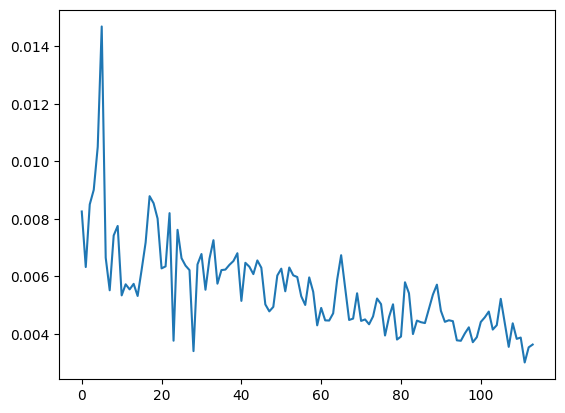

In [183]:
consumerindex= pd.read_excel('cpifruit.xlsx').T

consumerindex = consumerindex.drop(consumerindex.index[0])
consumerindex = consumerindex.drop(consumerindex.columns[[0, 1]], axis=1)
date_range = pd.date_range(start=pd.to_datetime('2005.01.31'), end= pd.to_datetime('2019.12.31'), freq='M')
date_range
new_index = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
consumerindex.index= date_range
consumerindex = consumerindex.rename(columns={2: 'cpi'})
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
consumerindex['Year'] = consumerindex.index.year
consumerindex['Month'] = consumerindex.index.month
# Merging on 'Year' and 'Month'
df = pd.merge(df, consumerindex[['Year', 'Month', 'cpi']], on=['Year', 'Month'], how='left')
# Optionally drop 'Year' and 'Month' if no longer needed
df.drop(['Year', 'Month'], axis=1, inplace=True)
df['normalized_p']= df['Price']/df['cpi']
stationary_test(df, 'normalized_p')
plt.plot(df.normalized_p)


In [184]:
# Apply logarithmic transformation
df['p_logs'] = np.log(df['Price'])

# Calculate first differences
df["p_diff"] = df['p_logs'].diff()

# Display the transformed datase
stationary_test(df, 'p_diff')
df = df.rename(columns={'p_diff': 'price','Date':'date'})
df= df.set_index('date')
df =df.resample('M').mean()
df= df.reset_index()
actprice=df[['date', 'Price']]
actprice.to_csv(f'actprice{product}.csv')

df.drop(['Price', 'cpi', 'normalized_p','p_logs'], axis=1, inplace=True)
final= final.merge(df, on='date')


ADF Statistic: -6.905166
p-value: 0.000000
The series is stationary.


In [185]:
df.head(10)

,date,price
0,2010-05-31,NaN
1,2010-06-30,-0.329304
2,2010-07-31,0.198851
3,2010-08-31,0.172713
4,2010-09-30,0.326571
5,2010-10-31,0.492753
6,2010-11-30,NaN
7,2010-12-31,NaN
8,2011-01-31,-0.944027
9,2011-02-28,-0.098440


### Dollar

In [186]:
df2 = pd.read_excel('EVDS (6).xlsx')

df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y')
df2= df2[df2.Date< pd.to_datetime('2020.1.1')]

df2.set_index('Date', inplace=True)
monthly_avg = df2.resample('M').mean()

# Apply logarithmic transformation
monthly_avg['dollar_logs'] = np.log(monthly_avg['Dollar'])
monthly_avg["dollar_diff"] = monthly_avg['dollar_logs'].diff()
stationary_test(monthly_avg, 'dollar_diff')

ADF Statistic: -7.221794
p-value: 0.000000
The series is stationary.


OIL PRICES

In [187]:
oilprices = pd.read_csv('scraped_gasdata.csv')
month_mapping = {
    'Ocak': '01', 'Şubat': '02', 'Mart': '03', 'Nisan': '04',
    'Mayıs': '05', 'Haziran': '06', 'Temmuz': '07', 'Ağustos': '08',
    'Eylül': '09', 'Ekim': '10', 'Kasım': '11', 'Aralık': '12'
}

# Function to convert date
def convert_date(date_str):
    for tr_month, num_month in month_mapping.items():
        if tr_month in date_str:
            date_str = date_str.replace(tr_month, num_month)
            break
    return datetime.strptime(date_str, '%d %m %Y').strftime('%d-%m-%Y')

# Apply the function to convert dates
oilprices['Date'] = oilprices['TARİH'].apply(convert_date)
oilprices['Date'] = pd.to_datetime(oilprices['Date'], format='%d-%m-%Y')
# Select only the required columns
filtered_oilprices = oilprices[['Date', 'KURŞUNSUZ BENZİN (TL/LT)']]
oilprices = filtered_oilprices.rename(columns={'Date': 'date', 'KURŞUNSUZ BENZİN (TL/LT)': 'gasprice'})
oilprices=oilprices[oilprices.date>pd.to_datetime('2004.12.31')]
oilprices=oilprices[oilprices.date<pd.to_datetime('2020.1.1')]
# Forward fill missing values

oilprices.set_index('date', inplace=True)

date_range = pd.date_range(start=oilprices.index.min(), end=oilprices.index.max(), freq='D')

# Reindex the DataFrame with the complete date range, filling missing values with NaN
oilprices = oilprices.reindex(date_range)
oilprices['gasprice'] = oilprices['gasprice'].fillna(method='ffill')
monthly_gas = oilprices.resample('M').mean()


                            OLS Regression Results                            
Dep. Variable:               gasprice   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2075.
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.34e-92
Time:                        19:32:32   Log-Likelihood:                 81.520
No. Observations:                 108   AIC:                            -155.0
Df Residuals:                     104   BIC:                            -144.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2664      0.166     -1.608      0.1

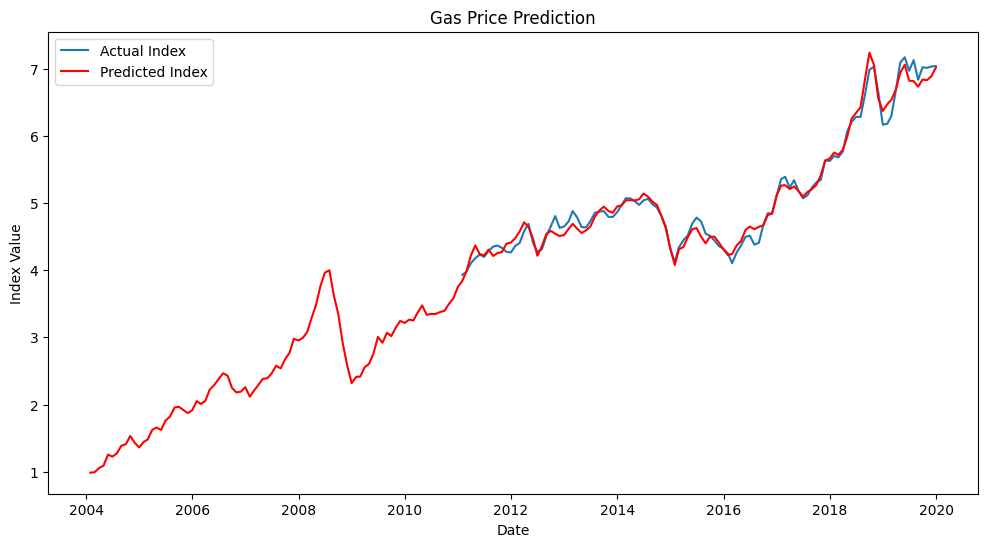

In [188]:
df3 = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name='Monthly Prices', skiprows=4, usecols=[0, 1])
df3.dropna(inplace=True)
# Rename the columns
df3 = df3.rename(columns={'Unnamed: 0': 'Date', 'Crude oil, average': 'crudeoil'})
df3['Date'] = pd.to_datetime(df3['Date'], format='%YM%m')
df3=df3[df3.Date>pd.to_datetime('2003.12.31')]
df3=df3[df3.Date<pd.to_datetime('2020.1.1')]
df3.set_index('Date', inplace=True)
monthly_crude = df3.resample('M').mean()

monthly_avg['time_trend'] = np.arange(len(monthly_avg))
merged= pd.merge(monthly_avg, monthly_crude, left_index=True, right_index=True, how='left')
merged['crudeoil'] = pd.to_numeric(merged['crudeoil'], errors='coerce')
non_numeric_values = merged['crudeoil'].isnull().sum()
non_numeric_values, merged.loc[merged['crudeoil'].isnull()]

y= monthly_gas['gasprice']
y = y.reset_index(drop=True)
X= merged[['time_trend', 'Dollar', 'crudeoil']]
X= X[X.index> pd.to_datetime('2010.12.31')]
X = X.reset_index(drop=True)
X = sm.add_constant(X)
X.dropna(inplace=True)
# Fit the model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

X= merged[['time_trend', 'Dollar','crudeoil']]
# X = X.reset_index(drop=True)

X = sm.add_constant(X)
X.dropna(inplace=True)

X['predicted'] = results.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(monthly_gas.index, monthly_gas, label='Actual Index')
plt.plot(monthly_avg.index, X['predicted'], label='Predicted Index', color='red')
plt.legend()
plt.title('Gas Price Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.show()



In [189]:

# Creating a full date range from start to end of your dataset
full_range = pd.date_range(start=merged.index.min(), end=merged.index.max(), freq='M')

# Reindexing the dataset
monthly_gas = monthly_gas.reindex(full_range)

monthly_gas['gasprice'].fillna(X['predicted'], inplace=True)

stationary_test(monthly_gas,'gasprice')

# Apply logarithmic transformation
monthly_gas['gas_logs'] = np.log(monthly_gas['gasprice'])

# Calculate first differences
monthly_gas["gas_diff"] = monthly_gas['gas_logs'].diff()

stationary_test(monthly_gas,'gas_diff')
monthly_gas.reset_index(inplace=True)

monthly_gas.drop(['gas_logs','gasprice'], axis=1,inplace=True)
monthly_gas = monthly_gas.rename(columns={'gas_diff': 'gasprice', 'index':'date'})
print(monthly_gas)
final= final.merge(monthly_gas, on='date')

ADF Statistic: -0.620695
p-value: 0.866237
The series is non-stationary and may need further differencing or transformation.
ADF Statistic: -9.695898
p-value: 0.000000
The series is stationary.
          date  gasprice
0   2004-01-31       NaN
1   2004-02-29  0.008206
2   2004-03-31  0.061288
3   2004-04-30  0.031955
4   2004-05-31  0.140482
..         ...       ...
187 2019-08-31 -0.041837
188 2019-09-30  0.026776
189 2019-10-31 -0.001234
190 2019-11-30  0.002895
191 2019-12-31  0.000948

[192 rows x 2 columns]


### LABOR

ADF Statistic: -5.018577
p-value: 0.000020
The series is stationary.


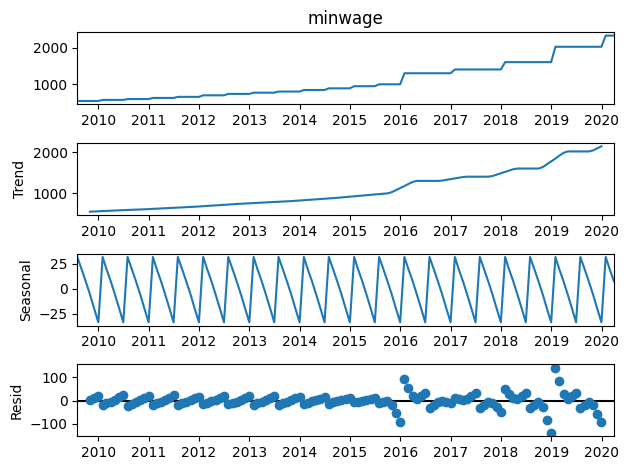

In [190]:
labor= pd.read_excel('labormin.xlsx')
labor['Date'] = pd.to_datetime(labor['Date'], format='%d.%m.%Y')
labor.set_index('Date', inplace=True)

date_range = pd.date_range(start=pd.to_datetime('2009.7.1'), end= pd.to_datetime('2020.3.31'), freq='D')

# Reindex the DataFrame with the complete date range, filling missing values with NaN
labor_full = labor.reindex(date_range)

# Forward fill the missing values in labor
labor_full['minwage'] = labor_full['minwage'].ffill()
labor=labor_full

monthly_labor =labor.resample('M').mean()
result = seasonal_decompose(monthly_labor['minwage'], model='additive', period=6)
monthly_labor['labor'] = result.resid
result.plot()
stationary_test(monthly_labor,'labor')
monthly_labor.reset_index(inplace=True)
monthly_labor.drop(['minwage'], axis=1,inplace=True)
monthly_labor = monthly_labor.rename(columns={'index':'date'})
final= final.merge(monthly_labor, on='date', how='left')

In [191]:
labor_full

,minwage
2009-07-01,546.48
2009-07-02,546.48
2009-07-03,546.48
2009-07-04,546.48
2009-07-05,546.48
...,...
2020-03-27,2324.71
2020-03-28,2324.71
2020-03-29,2324.71
2020-03-30,2324.71


In [192]:
labor= pd.read_excel('labormin.xlsx')
labor['Date'] = pd.to_datetime(labor['Date'], format='%d.%m.%Y')
labor.set_index('Date', inplace=True)

labor['wageinc']=1
monthly_labor =pd.DataFrame(labor['wageinc'].resample('M').mean())
date_range = pd.date_range(start=pd.to_datetime('2009.7.1'), end= pd.to_datetime('2020.3.31'), freq='M')

# Reindex the DataFrame with the complete date range, filling missing values with NaN
monthly_labor_full = monthly_labor.reindex(date_range)
monthly_labor_full = monthly_labor_full.fillna(0)
stationary_test(monthly_labor_full,'wageinc')


ADF Statistic: -1.185338
p-value: 0.679871
The series is non-stationary and may need further differencing or transformation.


In [193]:
final

,date,extreme,tempdiff,mindiff,maxdiff,raind,hum,tempdiff_man,mindiff_man,maxdiff_man,...,mindiff_bur,maxdiff_bur,raind_bur,tempdiff_izm,mindiff_izm,maxdiff_izm,raind_izm,price,gasprice,labor
0,2010-05-31,0,0.058524,0.060571,0.044355,-55.68,65.435484,0.049960,0.013822,0.022312,...,0.093737,0.014212,17.38,0.024540,-0.079948,0.044334,9.90,NaN,-0.041335,14.162327
1,2010-06-30,0,-0.011922,0.003317,-0.041361,4.37,62.447989,-0.023337,-0.015777,-0.054444,...,0.116111,-0.070588,75.31,-0.039036,-0.075295,-0.038616,46.59,-0.329304,0.004392,24.516931
2,2010-07-31,0,0.001565,0.030397,-0.029273,-0.97,65.630376,-0.011369,-0.023002,-0.024216,...,0.141497,-0.055332,17.06,0.022670,-0.018751,0.033785,2.90,0.198851,-0.000166,-22.690827
3,2010-08-31,0,0.076772,0.100544,0.055347,0.45,59.756720,0.065518,0.057037,0.058318,...,0.200932,0.037234,-1.23,0.076363,0.039907,0.101680,3.03,0.172713,0.008409,-14.162327
4,2010-09-30,0,0.057902,0.081957,0.030778,-84.51,58.413889,0.020815,0.016362,0.000011,...,0.160811,-0.016147,-2.89,0.035863,-0.032650,0.052768,-28.39,0.326571,0.005322,-5.633827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2019-08-31,0,0.040442,0.087696,0.028515,-0.39,49.615591,-0.013521,-0.033965,-0.002566,...,0.102415,-0.061657,11.39,0.054470,0.016497,0.081740,-11.58,-0.149212,-0.041837,-19.799827
112,2019-09-30,0,0.036796,0.100514,-0.016393,53.09,55.048276,-0.005420,-0.024933,-0.004405,...,0.150631,-0.016896,-72.23,0.025604,-0.026034,0.047040,26.58,-0.005764,0.026776,-7.512994
113,2019-10-31,1,0.137358,0.197748,0.044334,-27.74,52.752000,0.107562,0.101133,0.089893,...,0.253943,0.031096,17.12,0.055876,-0.015794,0.087438,12.89,-0.162859,-0.001234,-19.630609
114,2019-11-30,0,0.169613,0.255483,0.055093,33.59,62.453457,0.298214,0.274026,0.253390,...,0.724667,0.254819,-64.73,0.154707,0.103364,0.172305,-55.26,0.127561,0.002895,-56.152673


## INPUT PRICE INDEX

                            OLS Regression Results                            
Dep. Variable:                 pindex   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     655.0
Date:                Sat, 11 May 2024   Prob (F-statistic):           7.48e-29
Time:                        19:32:33   Log-Likelihood:                -149.75
No. Observations:                  48   AIC:                             303.5
Df Residuals:                      46   BIC:                             307.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.3867      3.191     15.161      0.0

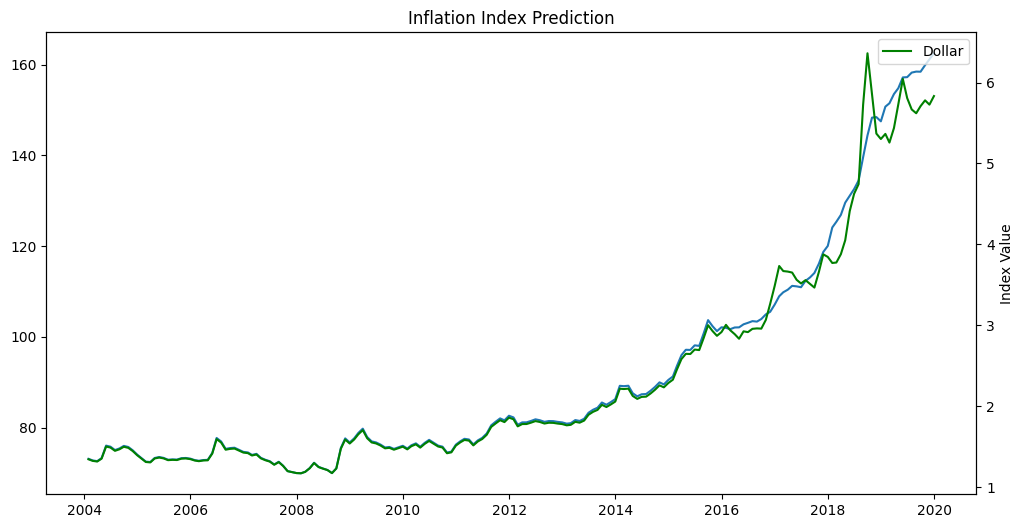

ADF Statistic: 3.901543
p-value: 1.000000
The series is non-stationary and may need further differencing or transformation.
ADF Statistic: -6.309714
p-value: 0.000000
The series is stationary.


In [194]:
df6= pd.read_excel('index.xlsx')
df6['Date'] = pd.to_datetime(df6['Date'], format='%d.%m.%Y')
df6.set_index('Date', inplace=True)
monthly_index = df6.resample('M').mean()
X = monthly_avg['Dollar'].dropna()  # Independent variable
X=X[X.index>pd.to_datetime('2015.12.31')]
y = monthly_index['pindex']  # Dependent variable
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Add a constant to the model (the intercept term)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())

X = monthly_avg['Dollar'].dropna()  # Independent variable

# Add a constant to the model (the intercept term)
X = sm.add_constant(X)

X['predicted'] = model.predict(X)

# Creating a full date range from start to end of your dataset
full_range = pd.date_range(start=monthly_avg.index.min(), end=monthly_avg.index.max(), freq='M')

# Reindexing the dataset
monthly_index= monthly_index.reindex(full_range)

monthly_index['pindex'].fillna(X['predicted'], inplace=True)

print(monthly_index)
plt.figure(figsize=(12, 6))
plt.plot(monthly_index.index, monthly_index, label='Actual Index')
plt.twinx()
plt.plot(monthly_avg.index, monthly_avg['Dollar'], label='Dollar', color='green')
plt.legend()
plt.title('Inflation Index Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.show()


stationary_test(monthly_index, 'pindex')

# Apply logarithmic transformation
monthly_index['pindex_logs'] = np.log(monthly_index['pindex'])
monthly_index["pindex_diff"] = monthly_index['pindex_logs'].diff()
stationary_test(monthly_index, 'pindex_diff')



monthly_avg.drop(['dollar_logs','Dollar','time_trend'], axis=1,inplace=True)

monthly_avg.reset_index(inplace=True)
monthly_avg = monthly_avg.rename(columns={'dollar_diff': 'usd','Date':'date'})
final= final.merge(monthly_avg, on='date')


# International Events
Russia banned touristic flights to Turkey. Russian tourists favorite destination is Antalya, and their presence is a huge resource of demand in the city, especially in tourism.
https://sputnikglobe.com/20151206/russian-sanctions-killed-tourist-business-antalya-1031332078.html

In [195]:
final.loc[(final['date'].dt.year == 2015) & (final['date'].dt.month.isin([6, 7, 8])), 'extreme'] = 1

In [196]:
final.tail(20)

,date,extreme,tempdiff,mindiff,maxdiff,raind,hum,tempdiff_man,mindiff_man,maxdiff_man,...,maxdiff_bur,raind_bur,tempdiff_izm,mindiff_izm,maxdiff_izm,raind_izm,price,gasprice,labor,usd
96,2018-05-31,0,0.119730,0.240888,0.056977,-77.49,60.722955,0.110380,0.173746,0.057328,...,-0.031002,35.48,0.113076,0.094046,0.100049,-38.62,-0.162859,0.023925,19.799827,0.085100
97,2018-06-30,1,-0.002883,0.115257,-0.078966,31.18,65.197260,0.003240,0.005026,-0.010999,...,-0.035871,-0.58,-0.005761,-0.036954,-0.003493,42.75,0.157062,0.011625,33.912764,0.047356
98,2018-07-31,0,0.015552,0.100221,-0.044644,3.62,57.048257,0.011744,0.005856,-0.012587,...,-0.026577,-22.60,0.020396,-0.014962,0.029586,6.34,0.034289,0.000000,-32.086661,0.025556
99,2018-08-31,0,0.004547,0.076222,-0.052999,-3.39,59.586022,0.002603,0.007262,-0.003235,...,-0.020810,-21.20,0.039404,0.015775,0.055069,7.32,-0.011300,0.052043,-19.799827,0.188025
100,2018-09-30,0,0.072882,0.145108,0.019443,5.91,50.619444,0.028805,0.058095,0.007106,...,-0.054577,50.65,0.065493,0.028564,0.079379,22.70,-0.005698,0.053731,-7.512994,0.105360
101,2018-10-31,0,0.058743,0.085656,-0.016318,-121.23,49.537433,0.020991,0.012066,0.018757,...,-0.021331,-45.49,-0.015903,-0.096544,0.017742,-35.04,0.087487,0.006767,-29.128109,-0.083066
102,2018-11-30,0,0.129308,0.202430,0.040772,28.74,59.496662,0.155684,0.273853,0.071629,...,-0.012530,58.08,0.034637,-0.027615,0.070248,90.88,0.075603,-0.055796,-84.645173,-0.086562
103,2018-12-31,0,0.107773,0.283140,-0.014989,57.20,64.275550,-0.064182,-0.203432,-0.055323,...,-0.114165,58.74,-0.171845,-0.376037,-0.087650,-39.60,0.079296,-0.075463,-140.162236,-0.012618
104,2019-01-31,1,0.103113,0.346364,-0.067376,454.30,75.660333,0.236945,0.636882,0.028218,...,0.066754,45.29,0.004706,0.033441,-0.060020,217.60,0.303255,0.002300,141.988339,0.011854
105,2019-02-28,0,0.151256,0.314176,0.032143,-23.47,64.707849,0.111986,0.072300,0.075000,...,-0.011529,-16.25,0.027068,-0.110119,0.088929,-110.56,-0.123178,0.018406,84.645173,-0.020196


In [197]:
final.to_csv(f'{product}.csv')